In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot


### 2. Загрузка данных

Данные обучения, которые включают в себя unit_sales с датой, store_nbr и item_nbr, а также уникальный идентификатор для маркировки строк.
Единицы unit_sales могут быть целыми (например, мешок чипсов) или плавающими (например, 1,5 кг сыра).

Отрицательные значения unit_sales представляют собой возврат этого конкретного элемента.

В столбце onpromotion указано, участвовал ли этот item_nbr в продвижении на указанную дату.

In [2]:
train = pd.read_csv('data/train.zip', index_col='id')
train.head()

C:\Users\User\AppData\Local\Temp\ipykernel_19320\1139991065.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('data/train.zip', index_col='id')


,date,store_nbr,item_nbr,unit_sales,onpromotion
id,,,,,
0,2013-01-01,25,103665,7.0,NaN
1,2013-01-01,25,105574,1.0,NaN
2,2013-01-01,25,105575,2.0,NaN
3,2013-01-01,25,108079,1.0,NaN
4,2013-01-01,25,108701,1.0,NaN


Данные о магазине, включая город, штат, тип и кластер.

In [3]:
stores = pd.read_csv('data/stores.zip')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Данные по продукту, включая категорию, класс и указание о том, скоропортящийся ли продукт.

Товары, отмеченные как скоропортящиеся, имеют вес 1.25 балла; в противном случае вес равен 1.0.

In [4]:
items = pd.read_csv('data/items.zip')
items.head()

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


Праздники и события

In [5]:
holiday_events = pd.read_csv('data/holidays_events.zip')
holiday_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Транзакции покупок

In [6]:
transactions = pd.read_csv('data/transactions.zip')
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


### 5. Характеристики и параметры временных рядов. Практика

Задание будем выполнять для магазина с номером 25. Для этого сгруппируйте данные по дате и суммируйте количество всех продаж.

In [7]:
df = train[train['store_nbr']==25].groupby('date').sum().reset_index().drop(['store_nbr', 'item_nbr', 'onpromotion'], axis = 1)
df.head()

,date,unit_sales
0,2013-01-01,2511.619
1,2013-01-02,5316.224
2,2013-01-03,4442.913
3,2013-01-04,4844.354
4,2013-01-05,5817.526


Сделайте сезонную декомпозицию.

In [8]:
df = df.set_index(pd.DatetimeIndex(df['date']))
df.drop(['date'], axis = 1, inplace = True)
df.head()

,unit_sales
date,
2013-01-01,2511.619
2013-01-02,5316.224
2013-01-03,4442.913
2013-01-04,4844.354
2013-01-05,5817.526


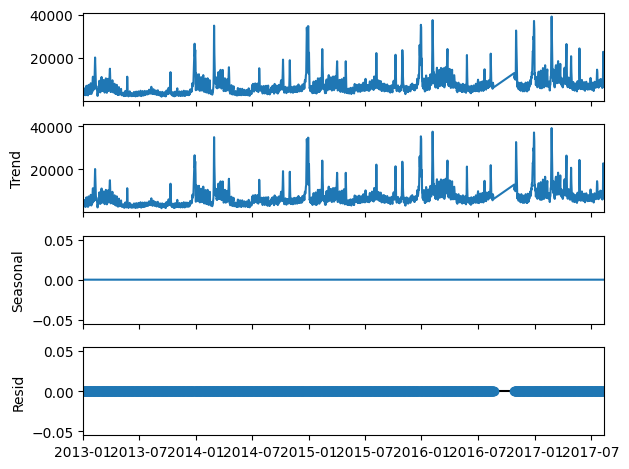

In [9]:
decomposition = seasonal_decompose(df, model='additive', period=1) 
decomposition.plot()
pyplot.show() # любуемся результатом

В Jupyter Notebook ответьте на вопросы:

1. Сколько элементов содержит исходный датасет?

2. Сколько элементов содержит шумовая часть?

3. Сколько числовых элементов содержит шумовая часть?

4. Сколько элементов содержит сезонная часть?

5. Сколько числовых элементов содержит трендовая часть?

In [10]:
trend_part = decomposition.trend # отдельно трендовая составляющаяя
seasonal_part = decomposition.seasonal # отдельно сезонная составляющаяя
residual_part = decomposition.resid # отдельно шум: то, что осталось

print(f'Элементов в исходном датасете: {len(df.index)}')
print(f'Элементов в шумовой части: {len(residual_part)}')
print(f'Ненулевых элементов в шумовой части: {len(residual_part[residual_part != 0])}')
print(f'Элементов в сезонной части: {len(seasonal_part)}')
print(f'Ненулевых элементов в сезонной части: {len(seasonal_part[seasonal_part != 0])}')
print(f'Элементов в трендовой части: {len(trend_part)}')
print(f'Ненулевых элементов в трендовой части: {len(trend_part[trend_part != 0])}')

Элементов в исходном датасете: 1618
Элементов в шумовой части: 1618
Ненулевых элементов в шумовой части: 0
Элементов в сезонной части: 1618
Ненулевых элементов в сезонной части: 0
Элементов в трендовой части: 1618
Ненулевых элементов в трендовой части: 1618


Выполните тест Дики-Фуллера.

In [11]:
test = adfuller(df['unit_sales'])
print ('adf: ', test[0] )
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: # проверка, больше ли критического полученное значение для нашего ряда 
    print ('ряд не стационарен')
else:
    print ('ряд стационарен')

adf:  -4.858992665318179
p-value:  4.188394192907804e-05
Critical values:  {'1%': -3.4344642432857992, '5%': -2.8633571955690647, '10%': -2.5677374399794197}
ряд стационарен


### 6. Особенности валидации временных рядов

Разбейте временной ряд, полученный в предыдущем юните, на три (train + test) набора. Для этого воспользуйтесь TimeSeriesSplit из sklearn.model_selection с параметром n_splits=3 и test_size=7. Наборы данных можно получить, вызвав метод split (временной ряд) у инициализированного TimeSeriesSplit.

In [12]:
tscv = TimeSeriesSplit(n_splits=3, test_size=7)
df_splited = tscv.split(df.unit_sales)

count = 1
for train_index, test_index in df_splited:
    print(f'Размер тренировочной выборки №{count}: ', len(train_index), f"Размер тестовой выборки №{count}: ", len(test_index))
    count +=1

Размер тренировочной выборки №1:  1597 Размер тестовой выборки №1:  7
Размер тренировочной выборки №2:  1604 Размер тестовой выборки №2:  7
Размер тренировочной выборки №3:  1611 Размер тестовой выборки №3:  7


### 8. Расчёт факторов при помощи pandas. Практика

Выберите временной ряд для одного магазина (можно использовать из прошлого задания).
Постройте скользящее среднее c окном 5.

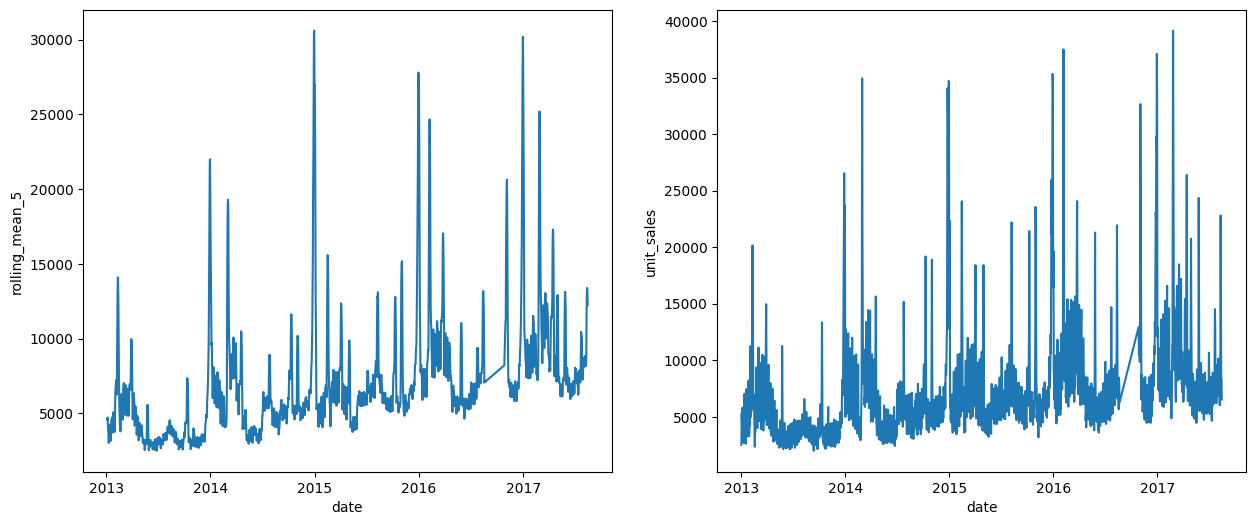

In [24]:
df['rolling_mean_5'] = df['unit_sales'].rolling(window=5).mean()

fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.lineplot(df['rolling_mean_5'],  ax=axes[0])
sns.lineplot(df['unit_sales'],  ax=axes[1]);

Постройте скользящее квадратическое отклонение c окном 5. 

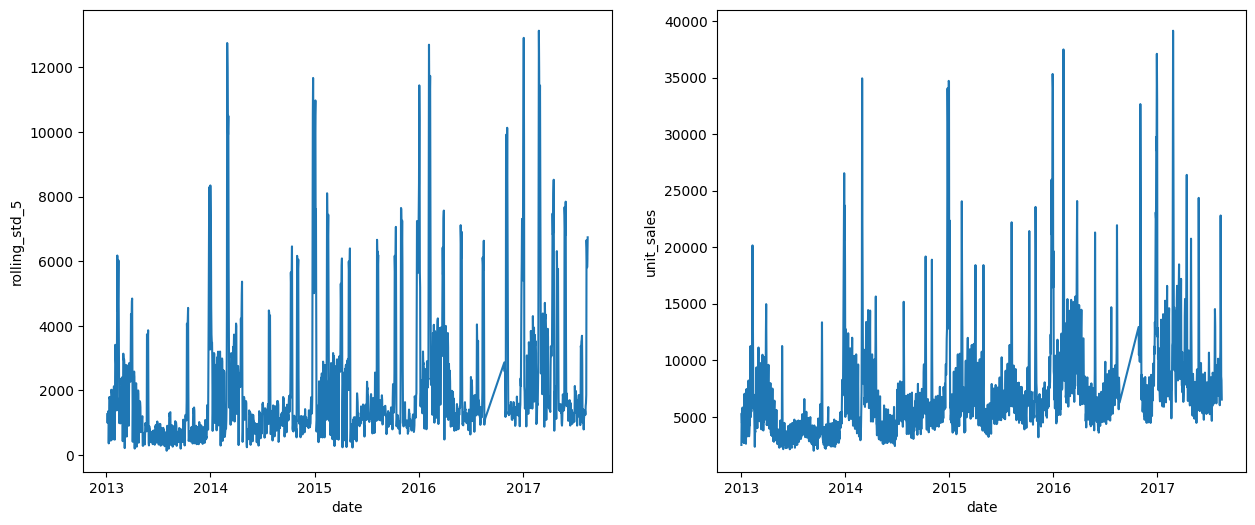

In [ ]:

df['rolling_std_5']  = df['unit_sales'].rolling(window=5).std()

fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.lineplot(df['rolling_std_5'],  ax=axes[0])
sns.lineplot(df['unit_sales'],  ax=axes[1]);

Постройте так называемые линии Боллинджера с окном в 30 (если этого позволяет выбранный ряд): добавьте к скользящему среднему скользящее стандартное отклонение, умноженное на три — верхняя линия Боллинджера; отнимите от скользящего среднего скользящее стандартное отклонение, умноженное на три — нижняя линия Боллинджера.
Отобразите эти оконные факторы на графике. 

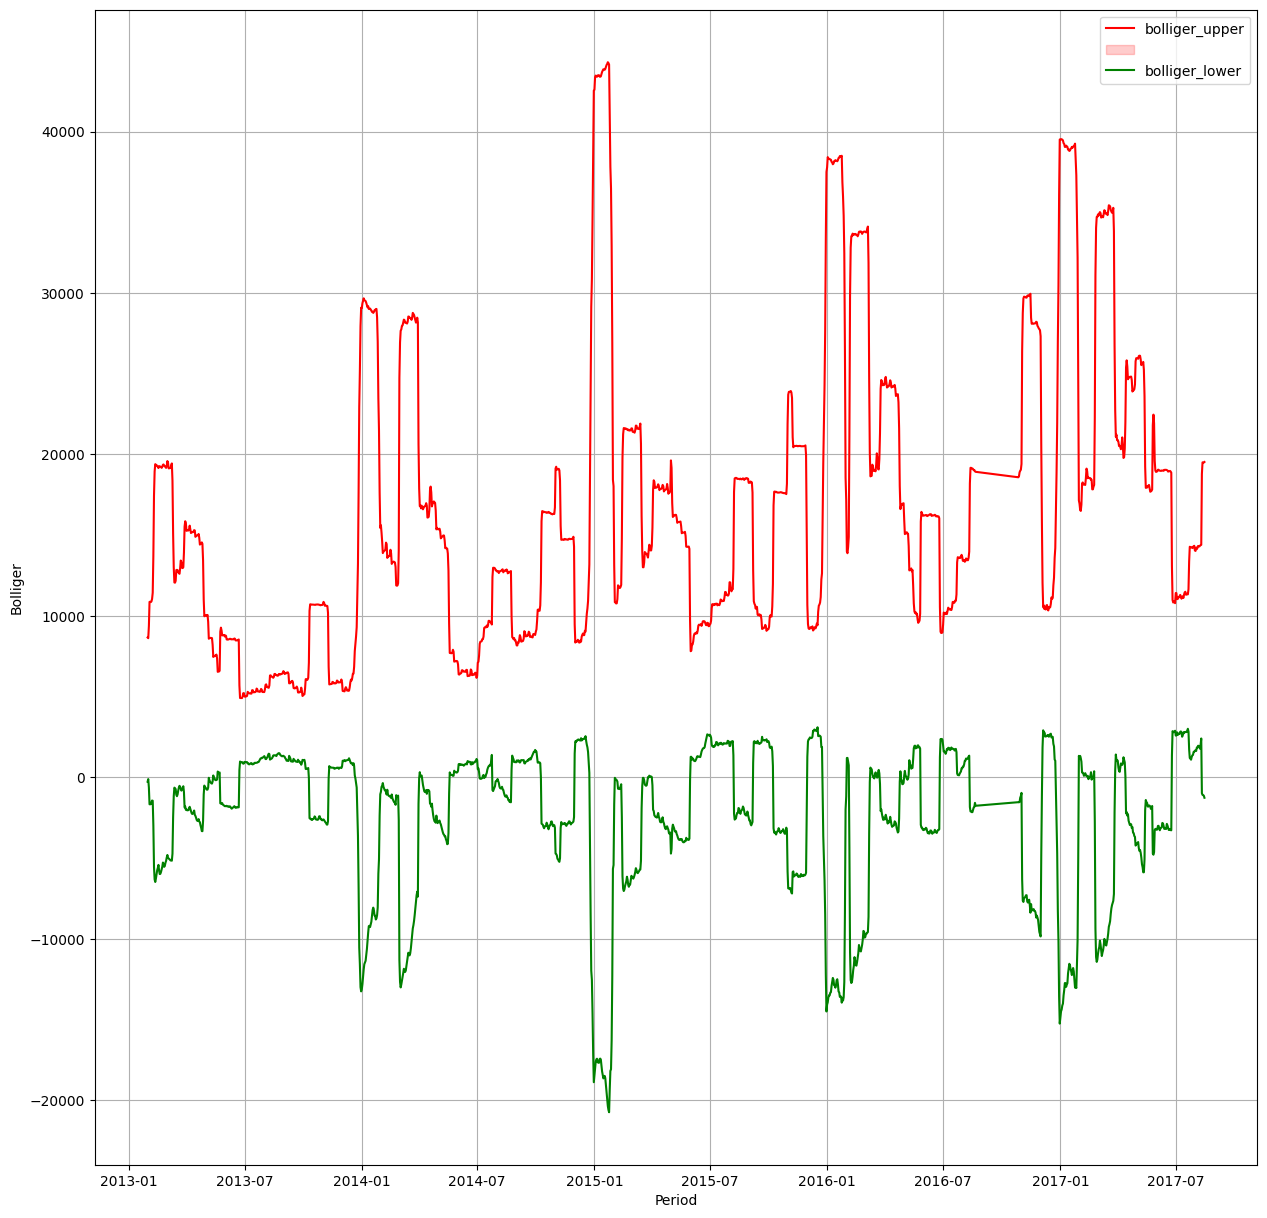

In [33]:
df['rolling_mean_30'] = df['unit_sales'].rolling(window=30).mean()
df['rolling_std_30']  = df['unit_sales'].rolling(window=30).std()

df['bolliger_upper'] = df['rolling_mean_30'] + df['rolling_std_30']*3
df['bolliger_lower'] = df['rolling_mean_30'] - df['rolling_std_30']*3

fig, axes = pyplot.subplots(1, figsize=(15, 15))

sns.lineplot(df['bolliger_upper'],  ax=axes, c='r')
sns.lineplot(df['bolliger_lower'],  ax=axes, c='g')
axes.legend(['bolliger_upper','', 'bolliger_lower'])
axes.set(xlabel='Period', ylabel='Bolliger')
axes.grid()

Постройте оконное среднее с окном в 10 точек.
Постройте экспоненциально среднее с окном в 7 точек (span=7).
Отобразите их на отдельном графике. 

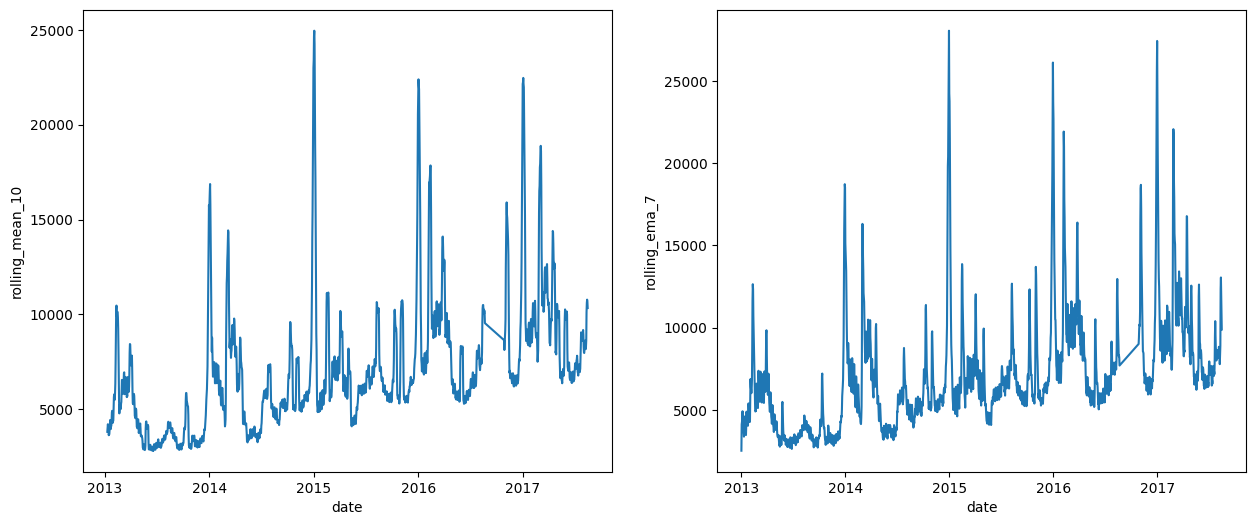

In [37]:
df['rolling_mean_10'] = df['unit_sales'].rolling(window=10).mean()
df['rolling_ema_7'] = df['unit_sales'].ewm(span=7).mean()

fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.lineplot(df['rolling_mean_10'],  ax=axes[0])
sns.lineplot(df['rolling_ema_7'],  ax=axes[1]);

Напишите свою скользящую функцию, которая будет являться средним арифметическим между максимальным и минимальным значением unit_sales, используя окно 10.

<Axes: xlabel='date', ylabel='my_func'>

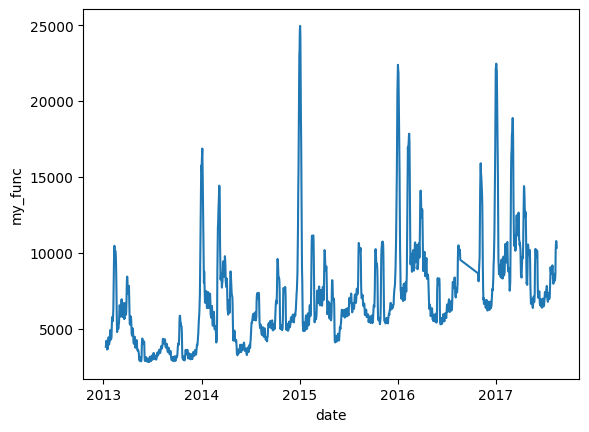

In [35]:
def my_func(value):
    return (max(value)-min(value)) / 2


df['my_func'] = df['unit_sales'].rolling(window=10).mean()
sns.lineplot(df['my_func'])

Постройте скользящее среднее с окном 50 и экспоненциальное скользящее среднее с окном 10 (span=10). Укажите индексы датафрейма, на которых одно скользящее пересекается с другим. Для этого вычтите из одно скользящего среднего другое, возьмите знак этой разности (np.sign), продифференциируйте его (diff()) и оставьте только те точки, где результат дифференциирования не равен нулю.

178


[Text(0.5, 0, 'Period'), Text(0, 0.5, 'Diff')]

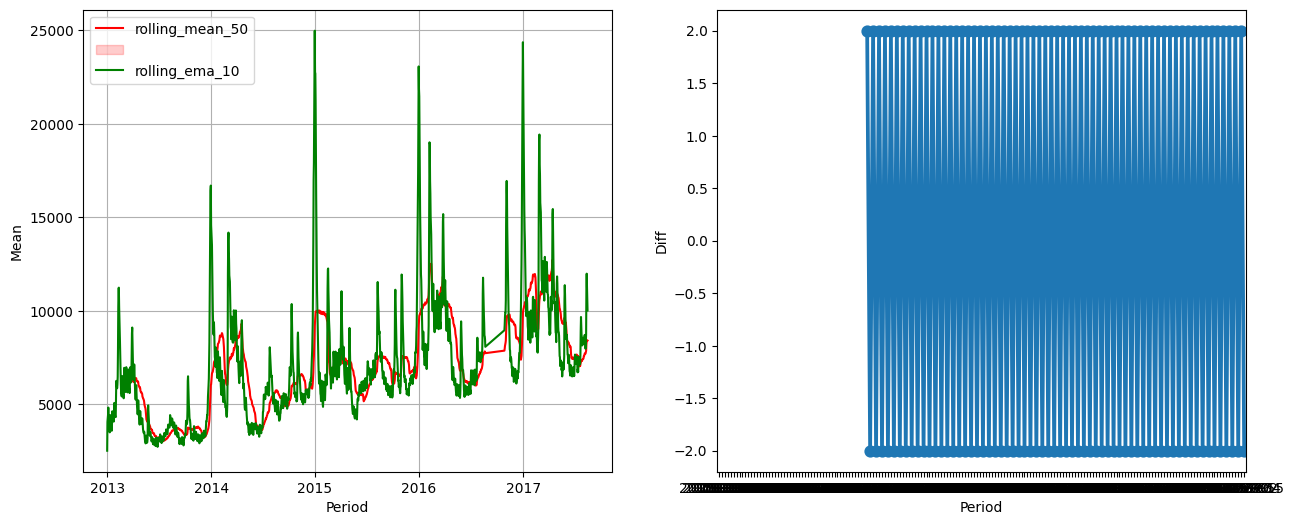

In [54]:
df['rolling_mean_50'] = df['unit_sales'].rolling(window=50).mean()
df['rolling_ema_10'] = df['unit_sales'].ewm(span=10).mean()

df['sign'] = np.sign(df['rolling_mean_50'] - df['rolling_ema_10'])
df['diff'] = df['sign'].diff()
print(len(df[df['diff'] != 0]['diff']))

fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.lineplot(df['rolling_mean_50'],  ax=axes[0], c='r')
sns.lineplot(df['rolling_ema_10'],  ax=axes[0], c='g')
axes[0].legend(['rolling_mean_50','', 'rolling_ema_10'])
axes[0].set(xlabel='Period', ylabel='Mean')
axes[0].grid()

sns.pointplot(df[df['diff'] != 0]['diff'], ax=axes[1]);
axes[1].set(xlabel='Period', ylabel='Diff')

Получите лаговые факторы с 7-го по 10-й предыдущих дня (лаг7, лаг8, лаг9, лаг10) и отобразите на графике. 

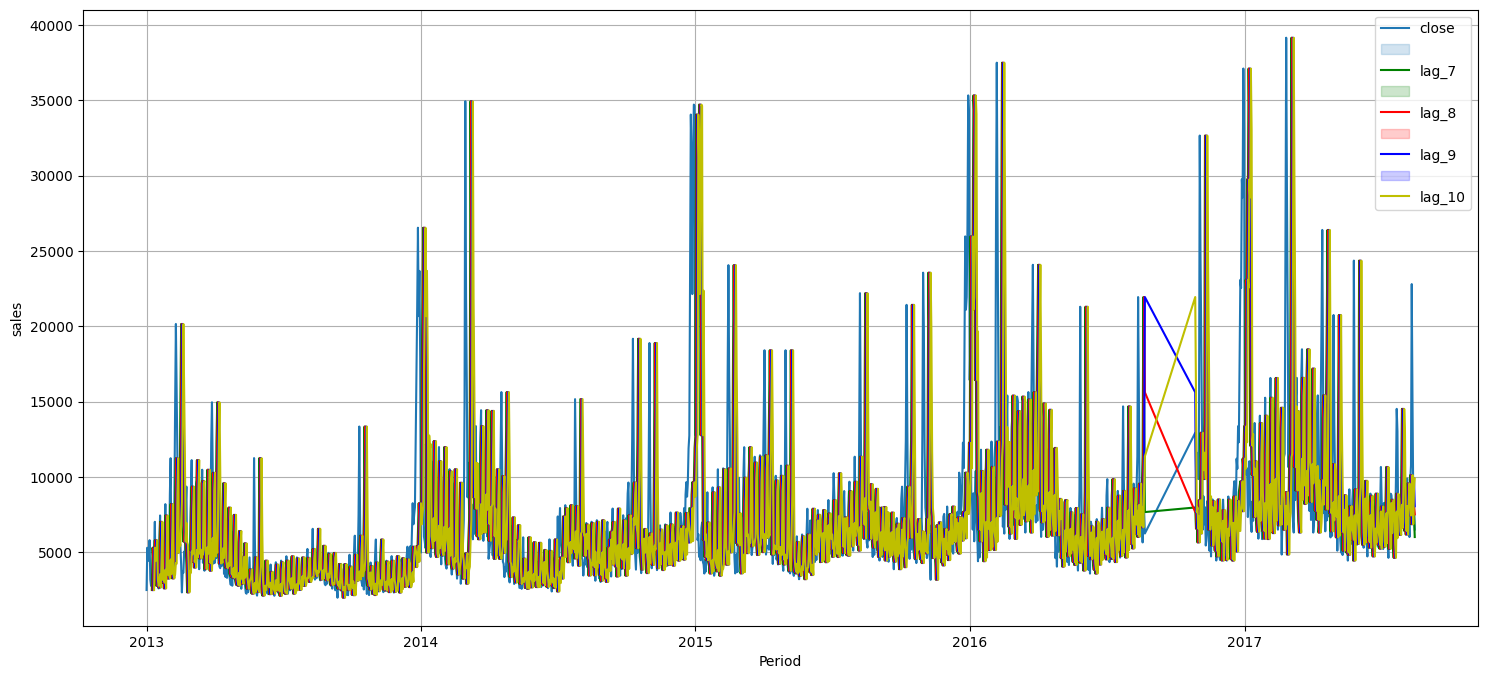

In [62]:
for i in range(7,11):
    df['lag_{}'.format(i)] = df['unit_sales'].shift(i)


## визуализируем
f, axes = pyplot.subplots(1, figsize=(18, 8))
sns.lineplot(df['unit_sales']) ## исходные данные
sns.lineplot(df['lag_' + str(7)], ax=axes, c='g') 
sns.lineplot(df['lag_' + str(8)], ax=axes,  c='r') 
sns.lineplot(df['lag_' + str(9)], ax=axes,  c='b') 
sns.lineplot(df['lag_' + str(10)], ax=axes,  c='y') 
axes.legend(['close', '', 'lag_7', '', 'lag_8', '', 'lag_9', '',  'lag_10'])
axes.set(xlabel='Period', ylabel='sales')
axes.grid()

### 10. ARIMA/SARIMA. Практика